This notebook serves as experimental notebook to better understand the style augmentations and other transforms that we apply to the images in order to find the best suited parameters for those

In [178]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [179]:
import torch
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import Compose, RandomResizedCrop, RandomGrayscale, RandomHorizontalFlip, GaussianBlur, ColorJitter, RandomSolarize, ToPILImage, ToTensor, RandomCrop, CenterCrop, Resize, Normalize

# set torch seed for reproducibility when using random image augmentations
torch.manual_seed(0)

In [525]:
from src.dataset import OurPatchLocalizationDataset, OriginalPatchLocalizationDataset, image_to_patches, sample_img_paths

In [181]:
from typing import List, Union, Tuple
import PIL
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

In [182]:
import skimage
from skimage.io import imshow, imread

In [465]:
RELIC_AUG_TRANSFORM = Compose([
    RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)), # certain
    RandomHorizontalFlip(p=0.5), # not certain
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # not certain
    RandomGrayscale(p=0.5), # not certain
    GaussianBlur(kernel_size=23, sigma=(0.1, 0.2)), # certain
    RandomSolarize(0.5, p=0.5), # not certain
])

# from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data
IMAGENET_NORMALIZATION_PARAMS = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225],
}

IMAGENET_NORMALIZATION = Normalize(**IMAGENET_NORMALIZATION_PARAMS)

IMAGENET_RESIZE = Compose([
    ToTensor(),
    Resize(256),
    CenterCrop(224),
])

## Helper Functions

In [693]:
def display_image(
    img: torch.Tensor, 
    normalization_params=None, 
    plt_title=None
):
    
    if normalization_params is not None:
        # unnormalize image according to normalization dict
        norm_mean, norm_std = np.array(normalization_params['mean']), np.array(normalization_params['std'])
        unnormalize = Normalize(mean=-norm_mean/norm_std, std=1/norm_std)
        img = unnormalize(img)
        
    npimg = img.numpy()
    # shuffle the color channels correctly
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plot
    plt.title(plt_title)
    plt.show()

def display_dataset_sample(ds_sample: Tuple[torch.Tensor, torch.Tensor], normalization_params=None):
    samples, labels = ds_sample
    # for every sample in this dataset sample (samples_per_image parameter)
    for imgs, label in zip(samples, labels):
        display_image(torchvision.utils.make_grid(imgs), normalization_params=normalization_params, plt_title=f"label: {label.item()}")
        

## Initialize datasets & dataloaders

In [508]:
sample = sample_img_paths(frac=.1)

In [509]:
img_paths = sample['images'].values

In [510]:
img_paths[6]

'./data/ILSVRC2012_img_val/ILSVRC2012_val_00012739.JPEG'

In [526]:
# initialization
ds_orig = OriginalPatchLocalizationDataset(img_paths=img_paths, pre_transform=Compose([IMAGENET_RESIZE, IMAGENET_NORMALIZATION]), samples_per_image=3)
dl_orig = torch.utils.data.DataLoader(ds_orig, batch_size=8, shuffle=True, num_workers=0)

ds_our = OurPatchLocalizationDataset(img_paths=img_paths, pre_transform=IMAGENET_RESIZE, aug_transform=RELIC_AUG_TRANSFORM, post_transform=IMAGENET_NORMALIZATION, samples_per_image=3)
dl_our = torch.utils.data.DataLoader(ds_our, batch_size=8, shuffle=True, num_workers=0)

#### Select image for tests

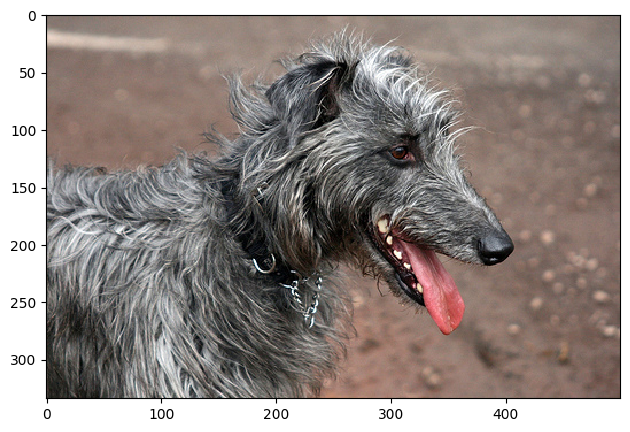

In [686]:
# select an arbitrary img_idx
img_idx=100
# display image from path
imshow(imread(ds_orig.img_paths[img_idx]))

## Analysis of OriginalPatchLocalizationDataset and OurPatchLocalizationDataset

In [687]:
# shape of the features of single dataset sample 
# samples_per_image, n_patches (2 without style augmentation, 3 with style augmentation), n_channels (RGB), img_height, img_width
print(ds_orig[0][0].shape)
print(ds_our[0][0].shape)

torch.Size([3, 2, 3, 224, 224])
torch.Size([3, 3, 3, 224, 224])


In [688]:
# shapes of features and labels in each batch of the dataloader
for X, y in dl_orig:
    print("features.shape")
    print("batch_size, samples_per_image, n_patches (2 for original, 3 for our), n_channels (RGB), img_height, img_width")
    print(X.shape)
    print("labels.shape")
    print("batch_size, samples_per_image")
    print(y.shape)
    break

features.shape
batch_size, samples_per_image, n_patches (2 for original, 3 for our), n_channels (RGB), img_height, img_width
torch.Size([8, 3, 2, 3, 224, 224])
labels.shape
batch_size, samples_per_image
torch.Size([8, 3])


In [689]:
# shapes of features and labels in each batch of the dataloader
for X, y in dl_our:
    print("features.shape")
    print("batch_size, samples_per_image, n_patches (2 for original, 3 for our), n_channels (RGB), img_height, img_width")
    print(X.shape)
    print("labels.shape")
    print("batch_size, samples_per_image")
    print(y.shape)
    break

features.shape
batch_size, samples_per_image, n_patches (2 for original, 3 for our), n_channels (RGB), img_height, img_width
torch.Size([8, 3, 3, 3, 224, 224])
labels.shape
batch_size, samples_per_image
torch.Size([8, 3])


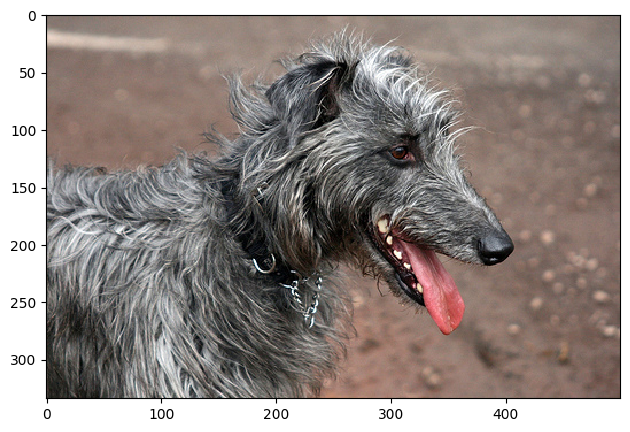

In [690]:
# display image from path
imshow(imread(ds_orig.img_paths[img_idx]))

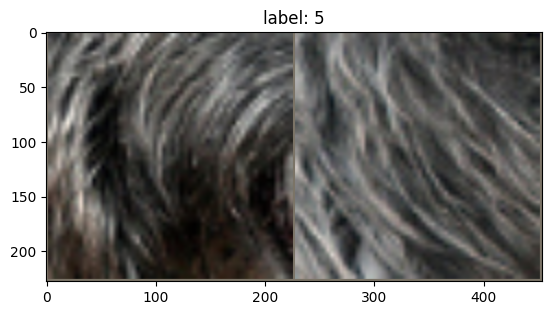

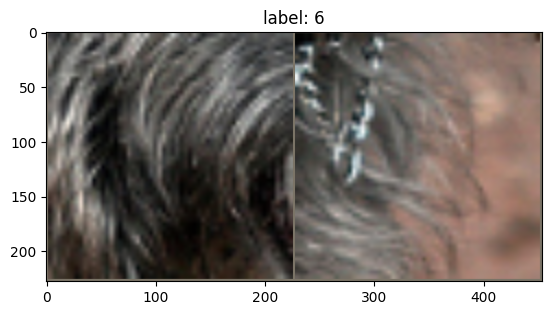

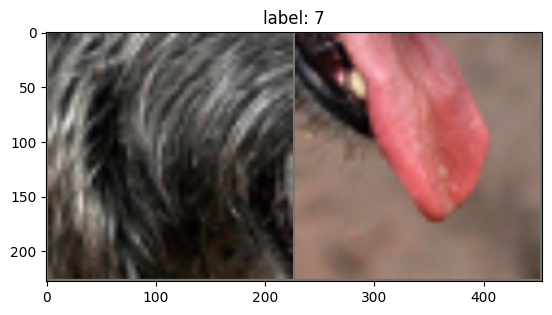

In [694]:
# display ds_orig dataset samples
display_dataset_sample(ds_orig[img_idx], normalization_params=IMAGENET_NORMALIZATION_PARAMS)

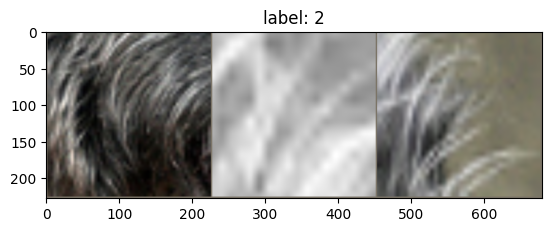

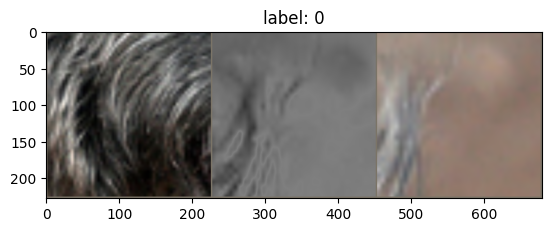

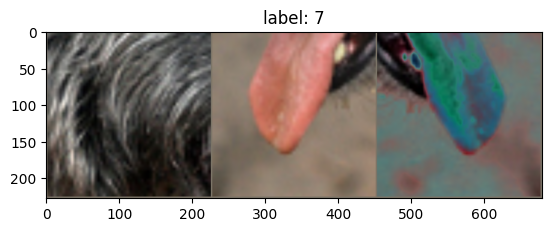

In [696]:
# display ds_our dataset samples
display_dataset_sample(ds_our[img_idx], normalization_params=IMAGENET_NORMALIZATION_PARAMS)

## Style Augmentations

In [676]:
RELIC_AUG_TRANSFORM = Compose([
    RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)), # certain
    RandomHorizontalFlip(p=0.5), # not certain
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # not certain
    RandomGrayscale(p=0.5), # not certain
    GaussianBlur(kernel_size=23, sigma=(0.1, 0.2)), # certain
    RandomSolarize(0.5, p=0.5), # not certain
])

CUSTOM_AUG_TRANSFORM = Compose([
    RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=0, contrast=0.2, saturation=0, hue=0),
    RandomGrayscale(p=0.5),
    GaussianBlur(kernel_size=23, sigma=(0.1, 0.2)),
    RandomSolarize(0.5, p=0.5),
])

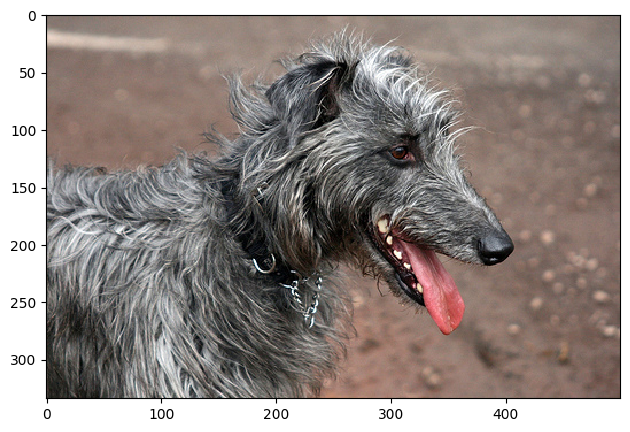

In [697]:
test_image = imread(ds_our.img_paths[img_idx])
imshow(test_image)

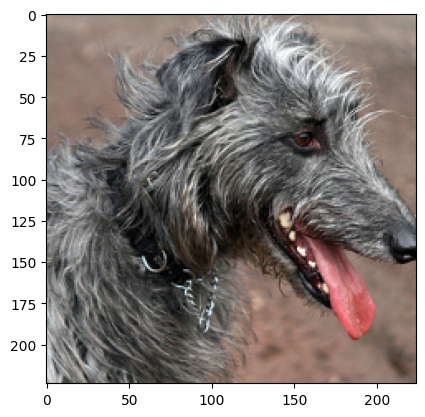

In [698]:
test_image_resized = IMAGENET_RESIZE(test_image)
display_image(test_image_resized, normalization_params=None)

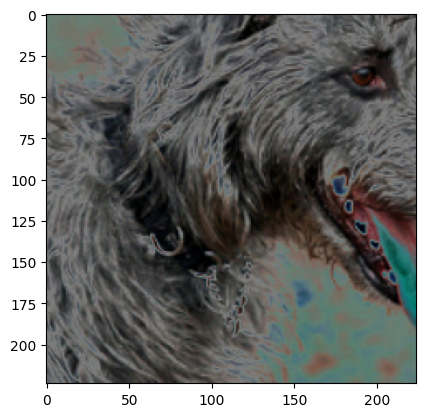

In [699]:
# display one random augmentation of the normalized test image (this cell can be re-run multiple times to get different results)
test_image_augmented = CUSTOM_AUG_TRANSFORM(test_image_resized)
display_image(test_image_augmented, normalization_params=None)

## Individual Transforms

### RandomResizedCrop

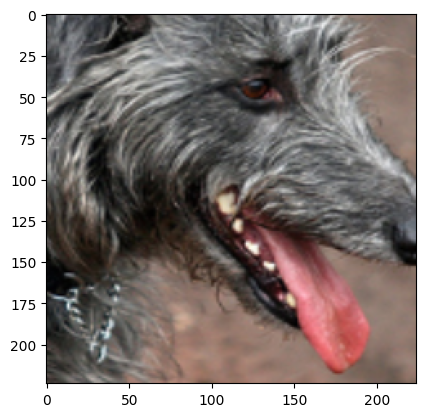

In [700]:
RRC = RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333))
test_image_augmented = RRC(test_image_resized)
display_image(test_image_augmented)

### RandomHorizontalFlip

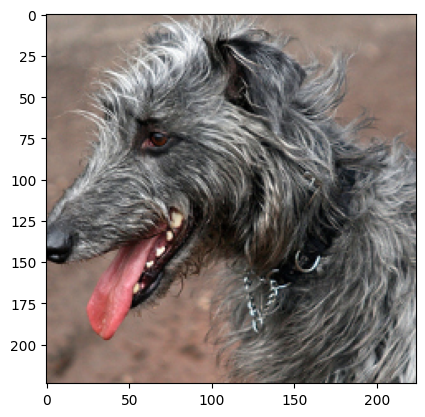

In [701]:
RHF = RandomHorizontalFlip(p=0.5)
test_image_augmented = RHF(test_image_resized)
display_image(test_image_augmented)

### ColorJitter

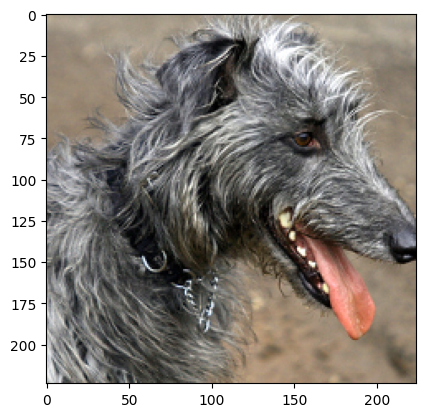

In [702]:
CJ = ColorJitter(brightness=.1, contrast=.1, saturation=.1, hue=.1)
test_image_augmented = CJ(test_image_resized)
display_image(test_image_augmented)

### RandomGrayscale

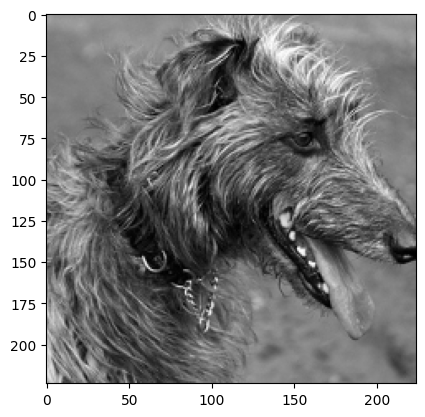

In [703]:
RG = RandomGrayscale(p=.5)
test_image_augmented = RG(test_image_resized)
display_image(test_image_augmented)

### GaussianBlur

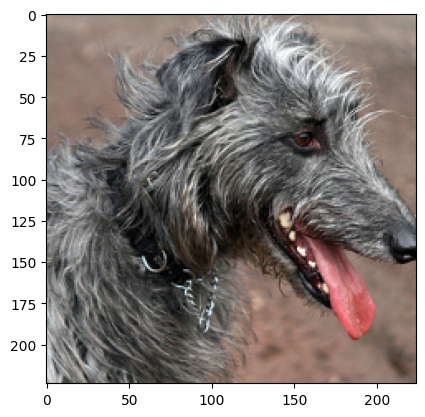

In [704]:
GB = GaussianBlur(kernel_size=23, sigma=(0.1, 0.2))
test_image_augmented = GB(test_image_resized)
display_image(test_image_augmented)

### RandomSolarize

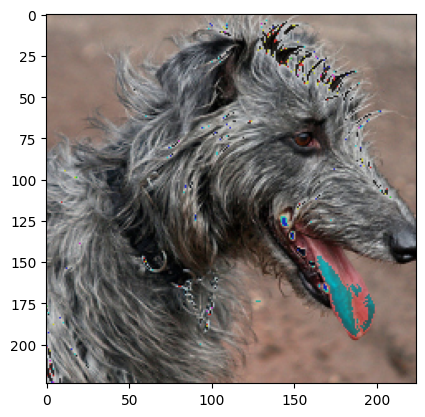

In [705]:
RS = RandomSolarize(.8, p=0.9)
test_image_augmented = RS(test_image_resized)
display_image(test_image_augmented)